In [1]:
import argparse
import codecs
import logging
import time

import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
import tqdm

from implicit.als import AlternatingLeastSquares
from implicit.approximate_als import (
    AnnoyAlternatingLeastSquares,
    FaissAlternatingLeastSquares,
    NMSLibAlternatingLeastSquares,
)
from implicit.bpr import BayesianPersonalizedRanking
from implicit.datasets.lastfm import get_lastfm
from implicit.lmf import LogisticMatrixFactorization
from implicit.nearest_neighbours import (
    BM25Recommender,
    CosineRecommender,
    TFIDFRecommender,
    bm25_weight,
)

In [2]:
# maps command line model argument to class name
MODELS = {
    "als": AlternatingLeastSquares,
    "nmslib_als": NMSLibAlternatingLeastSquares,
    "annoy_als": AnnoyAlternatingLeastSquares,
    "faiss_als": FaissAlternatingLeastSquares,
    "tfidf": TFIDFRecommender,
    "cosine": CosineRecommender,
    "bpr": BayesianPersonalizedRanking,
    "lmf": LogisticMatrixFactorization,
    "bm25": BM25Recommender,
}

In [3]:
def get_model(model_name):
    print("getting model %s" % model_name)
    model_class = MODELS.get(model_name)
    if not model_class:
        raise ValueError("Unknown Model '%s'" % model_name)

    # some default params
    if model_name.endswith("als"):
        params = {"factors": 64, "dtype": np.float32}
    elif model_name == "bm25":
        params = {"K1": 100, "B": 0.5}
    elif model_name == "bpr":
        params = {"factors": 63}
    elif model_name == "lmf":
        params = {"factors": 30, "iterations": 40, "regularization": 1.5}
    else:
        params = {}

    return model_class(**params)

# Download data from Movielens website
https://grouplens.org/datasets/movielens/20m/

In [5]:
import pandas as pd
import os
from datetime import datetime


import sys
sys.path.append("/Users/jahan/workspace/evaluation/src/")
import dataset
import metrics

data_path = "../datasets/ml-20m/"

## Load dataset

In [7]:
ratings_ = dataset.load("ratings.csv", path=data_path, delim=',')
ratings = dataset.parse_timestamp(ratings_)
# rename ratings columns
ratings = ratings.rename(columns={"userId": "user_id", "movieId": "item_id", "rating": "rating",  "datetime": "datetime"})
ratings.head(5)

,user_id,item_id,rating,datetime
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


## Movielense data stats

In [8]:
print("ratings columns: {}".format(ratings.columns))
print("No of rows in ratings df: {}".format(ratings.shape[0]))
print("Min datetime: {}, max datetime: {}".format(ratings["datetime"].min(), 
                                                  ratings["datetime"].max()))

ratings columns: Index(['userId', 'movieId', 'rating', 'timestamp', 'datetime'], dtype='object')
No of rows in ratings df: 20000263
Min datetime: 1995-01-09 11:46:44, max datetime: 2015-03-31 06:40:02


In [8]:
# use the last 30 days as test and anything prior as train dataset 
split_date = "2015-03-01 06:40:02.000000"
split_time = pd.datetime.strptime(split_date, '%Y-%m-%d %H:%M:%S.%f')

//anaconda/envs/recom/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
ratings.dtypes

user_id              int64
item_id              int64
rating             float64
datetime    datetime64[ns]
dtype: object

## Split train/test dataset

In [10]:
train_df, test_df = dataset.split(ratings, split_time)
print("Size of train dataset: {} & size of test dataset: {}".format(train_df.shape[0], test_df.shape[0]))

Size of train dataset: 19914017 & size of test dataset: 86246


## Train implicit

In [12]:
# map each user/movie to a unique numeric value
train_df['user_id'] = train_df['user_id'].astype("category")
train_df['item_id'] = train_df['item_id'].astype("category")

ratings_csr = coo_matrix((train_df['rating'].astype(np.float32), 
                         (train_df['item_id'].cat.codes.copy(), 
                          train_df['user_id'].cat.codes.copy()))).tocsr()

//anaconda/envs/recom/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda/envs/recom/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
items = np.array(train_df['item_id'].cat.categories)
users = np.array(train_df['user_id'].cat.categories)
ratings = ratings_csr

In [14]:
min_rating = 4.0
# remove things < min_rating, and convert to implicit dataset
# by considering ratings as a binary preference only
ratings.data[ratings.data < min_rating] = 0
ratings.eliminate_zeros()
ratings.data = np.ones(len(ratings.data))

In [15]:
model = AlternatingLeastSquares()
# lets weight these models by bm25weight.
ratings = (bm25_weight(ratings, B=0.9) * 5).tocsr()

In [16]:
# train the model
start = time.time()
model.fit(ratings)
print("Training time: {}".format(time.time() - start))


Training time: 198.75464391708374


## Generate ground truth

In [17]:
user_labels = dataset.generate_true_labels(test_df)

100%|██████████| 86246/86246 [00:13<00:00, 6317.85it/s]

No of users in test fold: 2056


In [18]:
# generate a map from train username to their user ids
train_users_dict = dict(enumerate(users.flatten(), 0))
training_ds = items, users, ratings

## Generate user recs for test users

In [19]:
def generate_user_recommendations(model, user_labels, train_username_to_id_map, training_ds):
    items, users, ratings = training_ds
    user_ratings = ratings.T.tocsr()
    user_recommendations = {}
    N = 10
    with tqdm.tqdm(total=len(user_labels)) as progress:
        for username in user_labels.keys():
            try:
                user_id = train_username_to_id_map[username]
                recomms_ = model.recommend(user_id, user_ratings, N)
                recomms = [(int(items[item_id]), score) for item_id, score in recomms_]
                user_recommendations[username] = recomms
            except:
                continue
            progress.update(1)
    return user_recommendations

In [20]:
user_recommendations = generate_user_recommendations(model, user_labels, train_users_dict, training_ds)

 99%|█████████▉| 2042/2056 [00:03<00:00, 602.59it/s]


## Compute recos metrics

In [27]:
def compute_metrics(user_recommendations, user_labels, k):
    sum_p_at_k, sum_recall_at_k = 0, 0
    users_no, cold_start_users = 0, 0
    with tqdm.tqdm(total=len(user_labels)) as progress:
        for username, actual_items_seen in user_labels.items():
            if username in user_recommendations:
                # grab only the top k recommended items for evaluation
                recommended_items = [item[0] for item in user_recommendations[username][:k]]
                # compute p@k
                sum_p_at_k += len(set(recommended_items) & set(actual_items_seen))/k
                sum_recall_at_k += len(set(recommended_items) & set(actual_items_seen))/len(actual_items_seen)
                users_no += 1
            else:
                cold_start_users += 1
                continue
            progress.update(1)
    # compute avg p@k
    avg_p_at_k = sum_p_at_k/users_no
    # compute avg recall at k
    avg_recall_at_k = sum_recall_at_k/users_no
    metrics = {"users_w_recos": users_no, "cold_start_users": cold_start_users}
    metrics["avg_p_at_k"] = avg_p_at_k
    metrics["avg_recall_at_k"] = avg_recall_at_k
    return metrics

## Compute metrics for different no of neighbors

In [37]:
als_metrics = {}

for k in range(1, 10):
    als_metrics[k] = compute_metrics(user_recommendations, user_labels, k)

 99%|█████████▉| 2042/2056 [00:00<00:00, 75034.77it/s]


In [38]:
for k in range(1, 10):
    print("No of users with recos: {}, No of cold users: {}".format(als_metrics[k]['users_w_recos'], 
                                                                    als_metrics[k]['cold_start_users']))
    print("avg_p_at_{}: {}%, avg_recall_at_{}: {}%".format(k, round(100*als_metrics[k]['avg_p_at_k'], 2), 
                                                           k, round(100*als_metrics[k]['avg_recall_at_k'],2)))

No of users with recos: 2042, No of cold users: 14
avg_p_at_1: 2.15%, avg_recall_at_1: 0.04%
No of users with recos: 2042, No of cold users: 14
avg_p_at_2: 2.11%, avg_recall_at_2: 0.07%
No of users with recos: 2042, No of cold users: 14
avg_p_at_3: 2.09%, avg_recall_at_3: 0.13%
No of users with recos: 2042, No of cold users: 14
avg_p_at_4: 1.97%, avg_recall_at_4: 0.16%
No of users with recos: 2042, No of cold users: 14
avg_p_at_5: 2.04%, avg_recall_at_5: 0.21%
No of users with recos: 2042, No of cold users: 14
avg_p_at_6: 2.01%, avg_recall_at_6: 0.24%
No of users with recos: 2042, No of cold users: 14
avg_p_at_7: 1.92%, avg_recall_at_7: 0.26%
No of users with recos: 2042, No of cold users: 14
avg_p_at_8: 1.88%, avg_recall_at_8: 0.28%
No of users with recos: 2042, No of cold users: 14
avg_p_at_9: 1.86%, avg_recall_at_9: 0.3%


In [21]:
user_stats = metrics.compute_basic_stats(user_recommendations, user_labels)
print("No of users with recos: {} & no of cold users: {}".format(user_stats['users_w_recos'], 
            user_stats['cold_start_users']))

 99%|█████████▉| 2042/2056 [00:00<00:00, 635321.47it/s]

No of users with recos: 2042 & no of cold users: 14


In [24]:
avg_p, avg_rec = [], []

for k in range(1, 11):
    als_perf[k] = metrics.compute_precision_and_recall_at_k(user_recommendations, user_labels, k)
    print("avg_p_at_{}: {}%, avg_recall_at_{}: {}%".format(k, round(100*als_perf[k]['avg_p_at_k'], 2), 
                                                           k, round(100*als_perf[k]['avg_recall_at_k'],2)))
    avg_p.append(round(100*als_perf[k]['avg_p_at_k'], 2))
    avg_rec.append(round(100*als_perf[k]['avg_recall_at_k'], 2))

  0%|          | 0/2056 [00:00<?, ?it/s]

avg_p_at_1: 2.2%, avg_recall_at_1: 0.05%
avg_p_at_2: 1.93%, avg_recall_at_2: 0.07%
avg_p_at_3: 1.84%, avg_recall_at_3: 0.12%
avg_p_at_4: 1.91%, avg_recall_at_4: 0.16%
avg_p_at_5: 1.94%, avg_recall_at_5: 0.2%
avg_p_at_6: 1.97%, avg_recall_at_6: 0.24%
avg_p_at_7: 1.92%, avg_recall_at_7: 0.26%
avg_p_at_8: 1.91%, avg_recall_at_8: 0.29%
avg_p_at_9: 1.88%, avg_recall_at_9: 0.3%


100%|██████████| 2056/2056 [00:00<00:00, 100824.14it/s]

avg_p_at_10: 1.82%, avg_recall_at_10: 0.32%


In [23]:
! pip install -U matplotlib

  Using cached matplotlib-3.3.3-cp36-cp36m-macosx_10_9_x86_64.whl (8.5 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
     |████████████████████████████████| 2.2 MB 2.0 MB/s eta 0:00:01
  Using cached kiwisolver-1.3.1-cp36-cp36m-macosx_10_9_x86_64.whl (61 kB)


In [26]:
import matplotlib.pyplot as plt

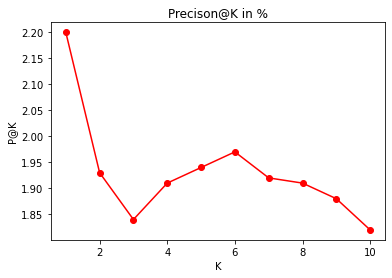

In [30]:
plt.plot(range(1,11), avg_p, 'ro-')
# plt.axis([0, 6, 0, 20])
plt.xlabel('K')
plt.ylabel('P@K')
plt.title('Precison@K in %')
plt.show()

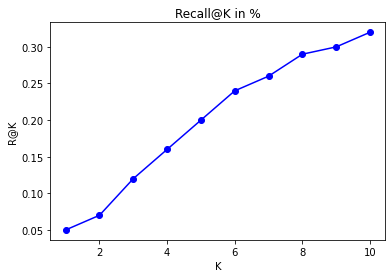

In [31]:
plt.plot(range(1,11), avg_rec, 'bo-')
# plt.axis([0, 6, 0, 20])
plt.xlabel('K')
plt.ylabel('R@K')
plt.title('Recall@K in %')
plt.show()